# Sudoku: Run Experiments on Pre-generated Data

This notebook runs the adaptive algorithm, baselines, and grid search
on pre-generated tree data.

**Input:** `results/sudoku_tree_data.json`  
**Output:** Plots + `results/sudoku_*.pkl`

### Sections
1. Setup & load data
2. Quick error-convergence experiment
3. Main pipeline: symmetric α=β sweep
4. Appendix: fix α, sweep β
5. Appendix: fix β, sweep α
6. Multi-sweep overlay plots
7. Reload & re-plot (for rebuttals)

## 1. Setup

In [1]:
import sys, os, time
sys.path.insert(0, os.path.abspath('..'))

from src.sudoku_experiments import (
    load_sudoku_tree_data,
    run_experiment,
    plot_all_error_rates,
    run_full_pipeline_sudoku,
    plot_accuracy_vs_latency_sudoku,
    save_results, load_results,
    plot_sweep_results,
)
from src.sudoku_experiments.sweep_plots import (
    plot_accuracy_vs_latency_multi_alpha_sudoku,
    plot_accuracy_vs_latency_multi_beta_sudoku,
)

SAVE_DIR = '../results'
os.makedirs(SAVE_DIR, exist_ok=True)
print('Imports OK')

Imports OK


In [3]:
tree_data = load_sudoku_tree_data('../results/sudoku_tree_data_n3_m3_500.json')
print(f'Loaded {len(tree_data)} puzzles')

✓ Loaded from ../results/sudoku_tree_data_n3_m3_500.json
  Puzzles: 500
  Depth: 3
  Branching: 3
  Total nodes: 19500
  Accuracy: 49.9%
Loaded 2 puzzles


## 2. Quick error-convergence experiment

Running experiment: noise_scale=0.1, n_passes=1
  Puzzles: 500, Effective: 500

Running Strong Baseline...
  Accuracy: 44.2%, Calls: 2659
Running Weak Baseline...
  Accuracy: 33.6%, Calls: 0

Running Adaptive (1 passes)...
  α=0.15, β=0.15: Final α̂=0.138, β̂=0.141, τ_A=0.766, τ_R=0.370


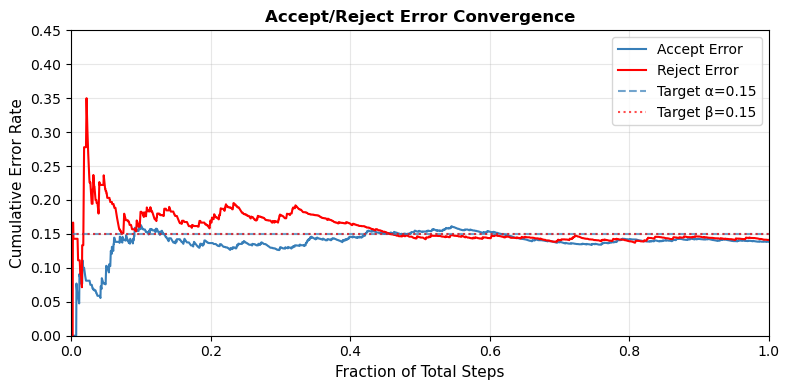

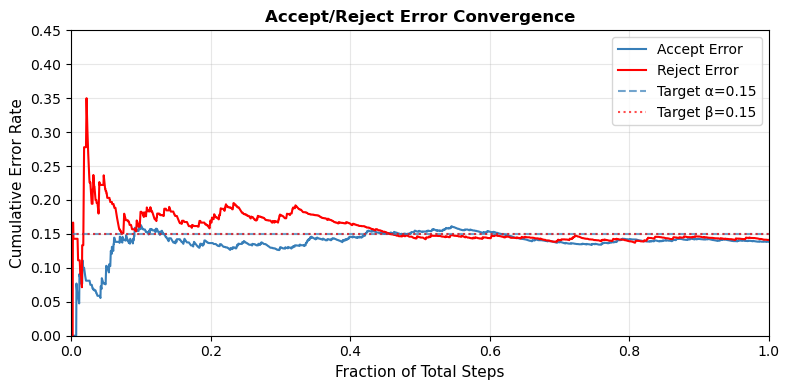

In [4]:
config = {
    'max_attempts_per_step': 5,
    'eta': 0.13, 'eta_R': 0.19,
    'P_a_init': 0.1, 'P_r_init': 0.1,
    'P_a_min': 0.1, 'P_r_min': 0.1,
}

results = run_experiment(
    tree_data, [(0.15, 0.15)], config,
    noise_scale=0.10, n_passes=1,
)
plot_all_error_rates(results)

## 3. Main pipeline: symmetric α=β sweep

Running Sudoku pipeline: 500 puzzles, noise=0.1
  Strong: 44.2% @ 5.32 strong calls/puzzle
  Weak (BoN-1): 24.4%
  Weak (BoN-2): 36.0%
  Weak (BoN-3): 39.6%

  (α=0.005, β=0.005):
    acc=43.4% ± 0.3%, strong=2.90 calls/puzzle

  (α=0.200, β=0.200):
    acc=36.4% ± 0.6%, strong=0.68 calls/puzzle

⏱ 0.4 min
✓ Results saved to: ../results/results_symmetric_noise0.1.pkl


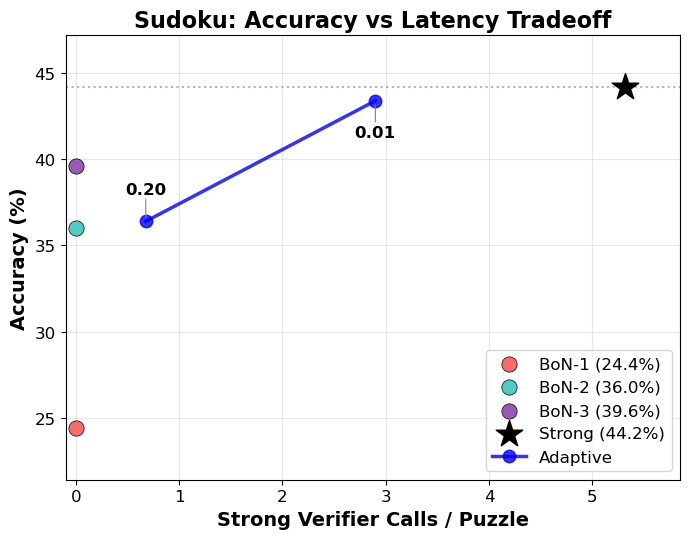

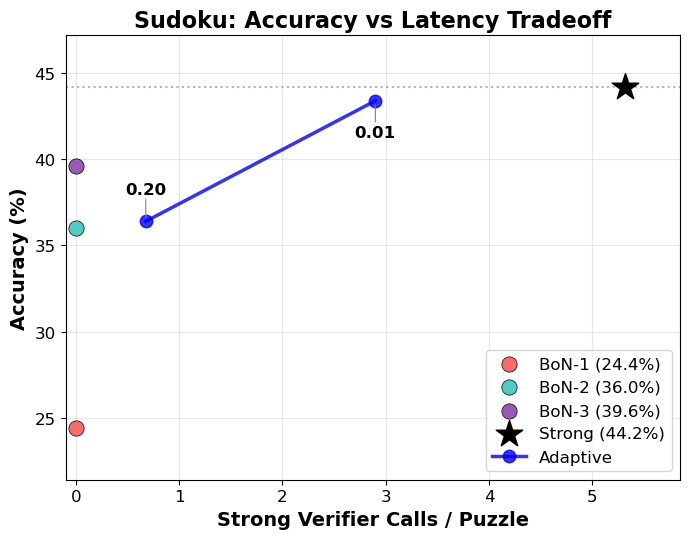

In [5]:
'''alpha_beta_values = [
    (0.001, 0.001), (0.005, 0.005), (0.01, 0.01),
    (0.03, 0.03), (0.05, 0.05), (0.07, 0.07),
    (0.10, 0.10), (0.15, 0.15), (0.2, 0.2), (0.3, 0.3),
]'''
alpha_beta_values = [
    (0.005, 0.005), (0.2, 0.2),
]

noise_scale = 0.1
n_runs = 3

start = time.time()
results_symmetric = run_full_pipeline_sudoku(
    tree_data, alpha_beta_values,
    noise_scale=noise_scale, n_runs=n_runs, n_workers=8,
    grid_search_mode='coarse_to_fine',
    weak_baseline_n_values=[1, 2, 3],
)
print(f'\n⏱ {(time.time()-start)/60:.1f} min')

save_results(results_symmetric, f'{SAVE_DIR}/results_symmetric_noise{noise_scale}.pkl')
plot_accuracy_vs_latency_sudoku(results_symmetric,
    save_path=f'{SAVE_DIR}/plot_symmetric.png')

## 4. Appendix: fix α, sweep β

In [13]:
#sweep_values = [0.001, 0.005, 0.01, 0.03, 0.05, 0.07, 0.10, 0.15, 0.2, 0.3]
#fixed_values = [0.01, 0.05, 0.1, 0.2]
sweep_values = [0.005, 0.05]
fixed_values = [0.1, 0.2]
noise_scale = 0.1
n_runs = 3

alpha_fixed_results = {}

for fixed_alpha in fixed_values:
    print(f"\n{'='*60}")
    print(f"Running: α={fixed_alpha} (fixed), β=sweep")
    print(f"{'='*60}")

    ab_vals = [(fixed_alpha, beta) for beta in sweep_values]
    start = time.time()

    res = run_full_pipeline_sudoku(
        tree_data, ab_vals,
        noise_scale=noise_scale, n_runs=n_runs, n_workers=8,
        grid_search_mode='coarse_to_fine',
        weak_baseline_n_values=[1, 2, 3],
    )
    print(f'⏱ {(time.time()-start)/60:.1f} min')

    save_results(res, f'{SAVE_DIR}/results_alpha{fixed_alpha}_betasweep_noise{noise_scale}.pkl')
    alpha_fixed_results[fixed_alpha] = res

print(f'\nDone — {len(alpha_fixed_results)} α-fixed sweeps')


Running: α=0.1 (fixed), β=sweep
Running Sudoku pipeline: 500 puzzles, noise=0.1
  Strong: 44.2% @ 5.32 strong calls/puzzle
  Weak (BoN-1): 24.4%
  Weak (BoN-2): 36.0%
  Weak (BoN-3): 39.6%

  (α=0.100, β=0.005):
    acc=40.9% ± 1.4%, strong=2.11 calls/puzzle

  (α=0.100, β=0.050):
    acc=40.1% ± 0.4%, strong=1.57 calls/puzzle
⏱ 0.4 min
✓ Results saved to: ../results/results_alpha0.1_betasweep_noise0.1.pkl

Running: α=0.2 (fixed), β=sweep
Running Sudoku pipeline: 500 puzzles, noise=0.1
  Strong: 44.2% @ 5.32 strong calls/puzzle
  Weak (BoN-1): 24.4%
  Weak (BoN-2): 36.0%
  Weak (BoN-3): 39.6%

  (α=0.200, β=0.005):
    acc=37.5% ± 1.0%, strong=1.74 calls/puzzle

  (α=0.200, β=0.050):
    acc=35.1% ± 0.4%, strong=0.94 calls/puzzle
⏱ 0.4 min
✓ Results saved to: ../results/results_alpha0.2_betasweep_noise0.1.pkl

Done — 2 α-fixed sweeps


✓ Saved: ../results/plot_alpha0.1_betasweep.png


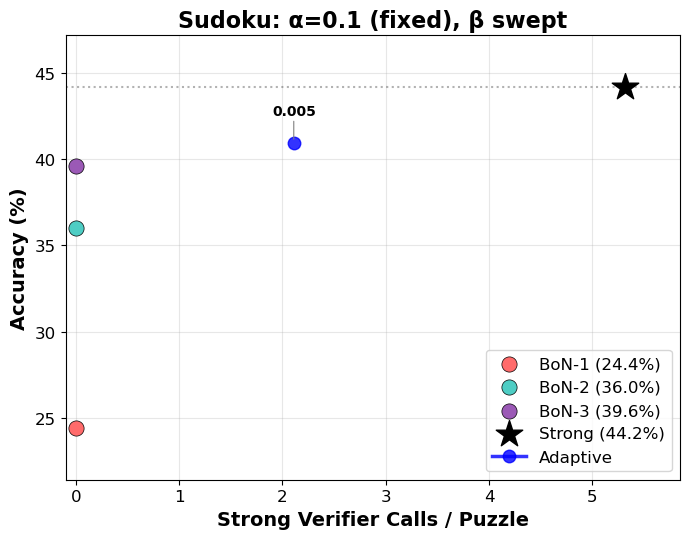

✓ Saved: ../results/plot_alpha0.2_betasweep.png


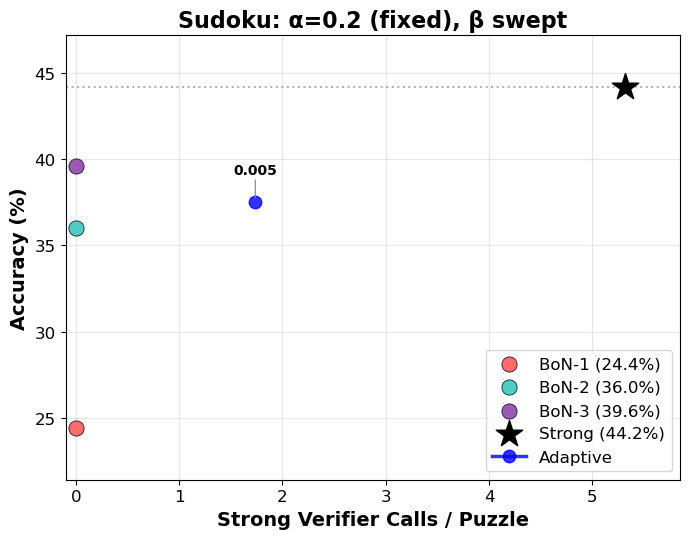

In [7]:
# Individual plots for each fixed α
for fixed_alpha, res in sorted(alpha_fixed_results.items()):
    plot_sweep_results(
        res, fixed_param='alpha', fixed_value=fixed_alpha,
        save_path=f'{SAVE_DIR}/plot_alpha{fixed_alpha}_betasweep.png',
    )

## 5. Appendix: fix β, sweep α

In [8]:
beta_fixed_results = {}

for fixed_beta in fixed_values:
    print(f"\n{'='*60}")
    print(f"Running: α=sweep, β={fixed_beta} (fixed)")
    print(f"{'='*60}")

    ab_vals = [(alpha, fixed_beta) for alpha in sweep_values]
    start = time.time()

    res = run_full_pipeline_sudoku(
        tree_data, ab_vals,
        noise_scale=noise_scale, n_runs=n_runs, n_workers=8,
        grid_search_mode='coarse_to_fine',
        weak_baseline_n_values=[1, 2, 3],
    )
    print(f'⏱ {(time.time()-start)/60:.1f} min')

    save_results(res, f'{SAVE_DIR}/results_alphasweep_beta{fixed_beta}_noise{noise_scale}.pkl')
    beta_fixed_results[fixed_beta] = res

print(f'\nDone — {len(beta_fixed_results)} β-fixed sweeps')


Running: α=sweep, β=0.1 (fixed)
Running Sudoku pipeline: 500 puzzles, noise=0.1
  Strong: 44.2% @ 5.32 strong calls/puzzle
  Weak (BoN-1): 24.4%
  Weak (BoN-2): 36.0%
  Weak (BoN-3): 39.6%

  (α=0.001, β=0.100):
    acc=42.2% ± 0.2%, strong=2.28 calls/puzzle

  (α=0.005, β=0.100):
    acc=40.6% ± 0.5%, strong=1.84 calls/puzzle
⏱ 0.4 min
✓ Results saved to: ../results/results_alphasweep_beta0.1_noise0.1.pkl

Running: α=sweep, β=0.2 (fixed)
Running Sudoku pipeline: 500 puzzles, noise=0.1
  Strong: 44.2% @ 5.32 strong calls/puzzle
  Weak (BoN-1): 24.4%
  Weak (BoN-2): 36.0%
  Weak (BoN-3): 39.6%

  (α=0.001, β=0.200):
    acc=40.9% ± 0.9%, strong=1.82 calls/puzzle

  (α=0.005, β=0.200):
    acc=40.7% ± 0.8%, strong=1.66 calls/puzzle
⏱ 0.4 min
✓ Results saved to: ../results/results_alphasweep_beta0.2_noise0.1.pkl

Done — 2 β-fixed sweeps


✓ Saved: ../results/plot_alphasweep_beta0.1.png


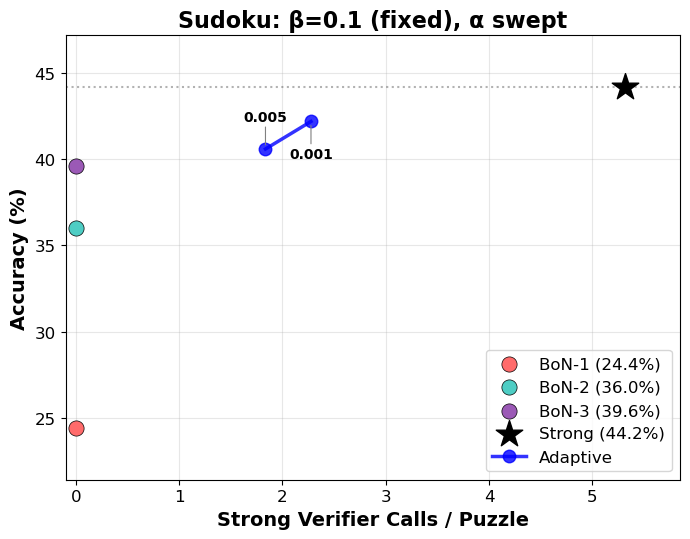

✓ Saved: ../results/plot_alphasweep_beta0.2.png


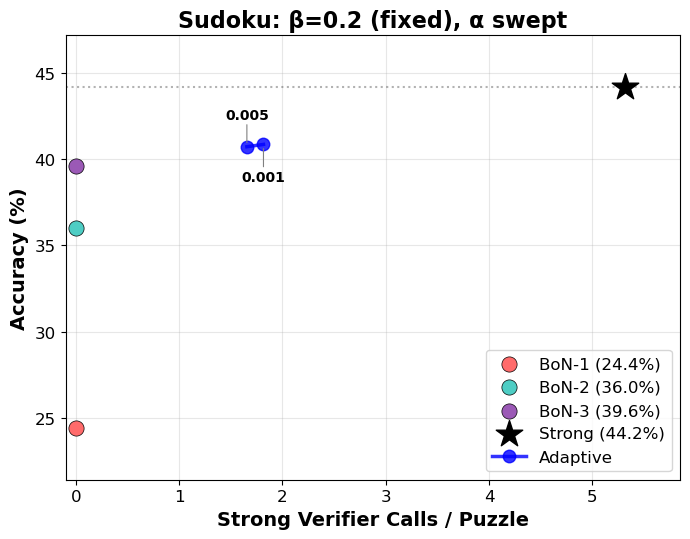

In [9]:
# Individual plots for each fixed β
for fixed_beta, res in sorted(beta_fixed_results.items()):
    plot_sweep_results(
        res, fixed_param='beta', fixed_value=fixed_beta,
        save_path=f'{SAVE_DIR}/plot_alphasweep_beta{fixed_beta}.png',
    )

## 6. Multi-sweep overlay plots

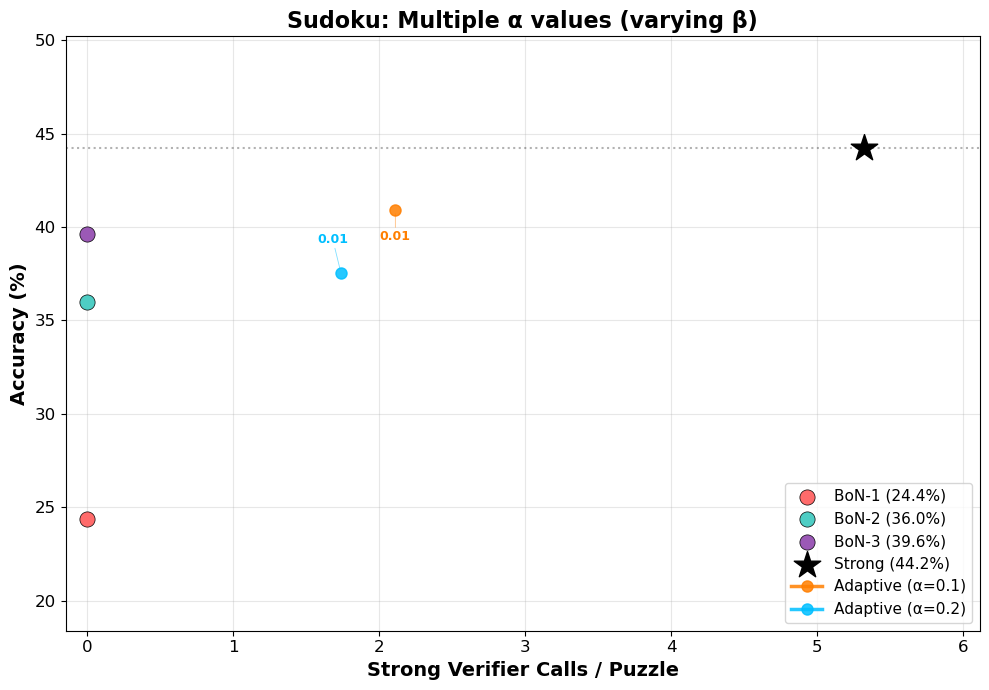

In [10]:
# All α-fixed curves on one plot (each curve = different fixed α, x-axis varies with β)
if alpha_fixed_results:
    plot_accuracy_vs_latency_multi_alpha_sudoku(
        alpha_fixed_results,
        save_path=f'{SAVE_DIR}/plot_multi_alpha_betasweep.png',
        annotate_labels=True,
    )

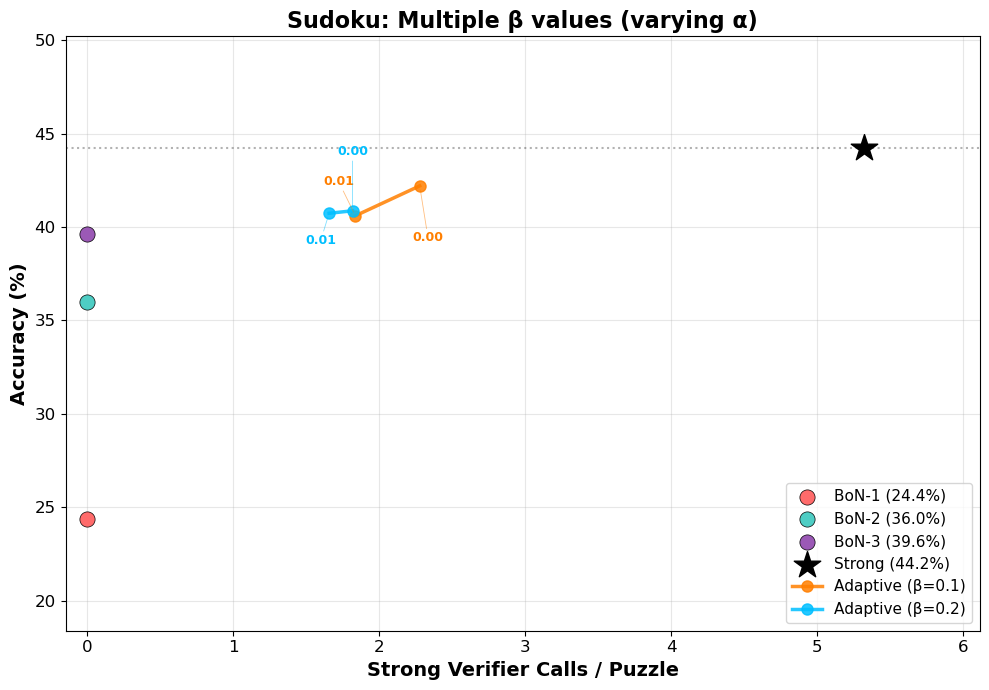

In [11]:
# All β-fixed curves on one plot (each curve = different fixed β, x-axis varies with α)
if beta_fixed_results:
    plot_accuracy_vs_latency_multi_beta_sudoku(
        beta_fixed_results,
        save_path=f'{SAVE_DIR}/plot_multi_beta_alphasweep.png',
        annotate_labels=True,
    )

## 7. Reload & re-plot (for rebuttals)

Skip all computation above — just load saved `.pkl` files and regenerate plots.

✓ Results loaded from: ../results/results_symmetric_noise0.1.pkl


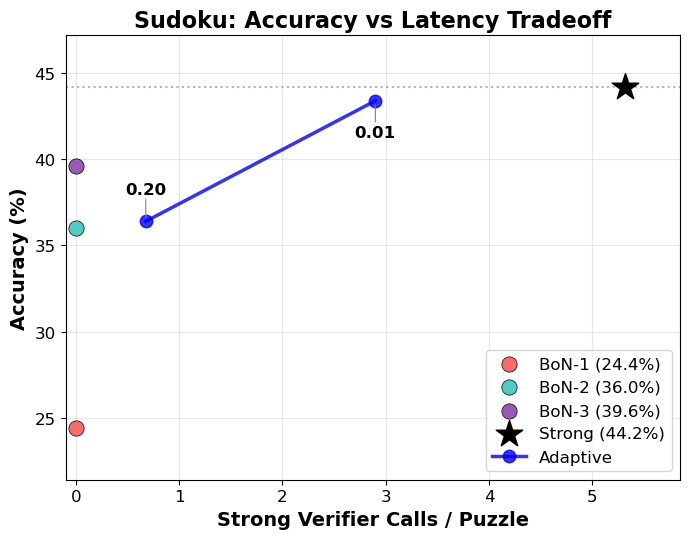

α=0.01 not found
α=0.05 not found
✓ Results loaded from: ../results/results_alpha0.1_betasweep_noise0.1.pkl
✓ Saved: ../results/plot_alpha0.1_betasweep.png


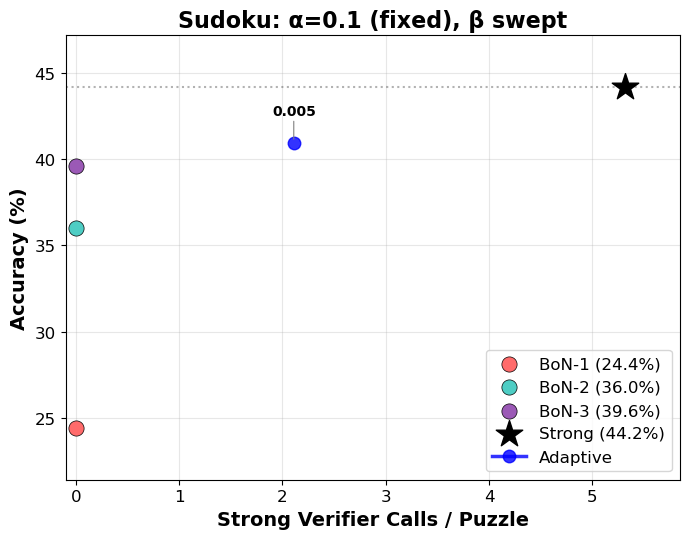

✓ Results loaded from: ../results/results_alpha0.2_betasweep_noise0.1.pkl
✓ Saved: ../results/plot_alpha0.2_betasweep.png


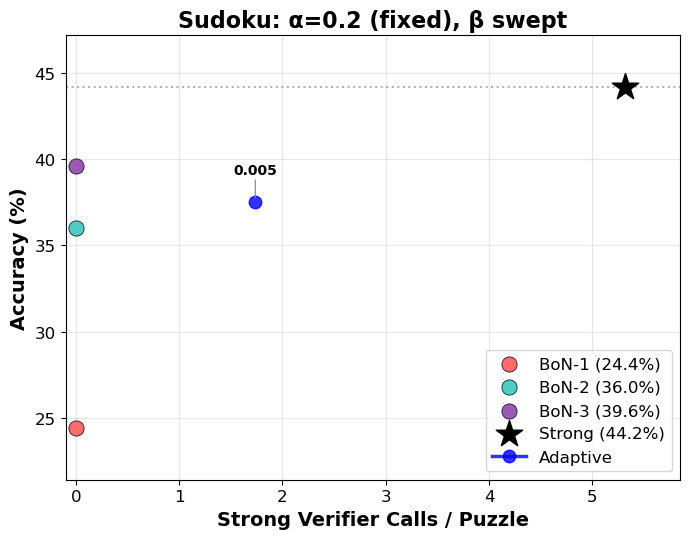

β=0.01 not found
β=0.05 not found
✓ Results loaded from: ../results/results_alphasweep_beta0.1_noise0.1.pkl
✓ Saved: ../results/plot_alphasweep_beta0.1.png


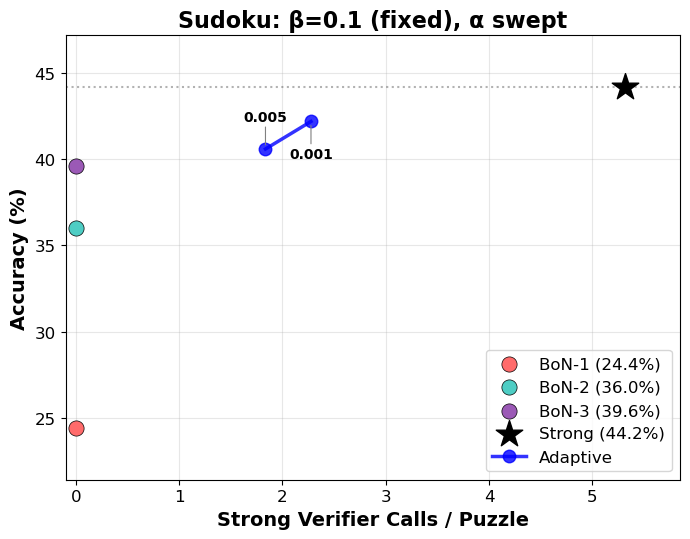

✓ Results loaded from: ../results/results_alphasweep_beta0.2_noise0.1.pkl
✓ Saved: ../results/plot_alphasweep_beta0.2.png


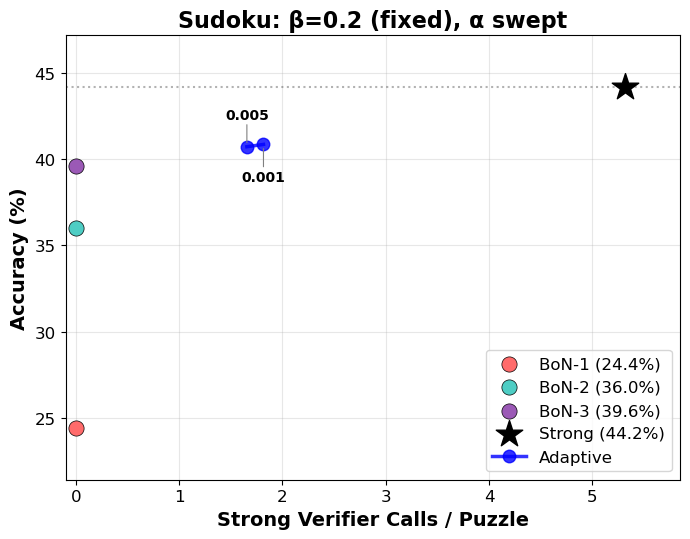

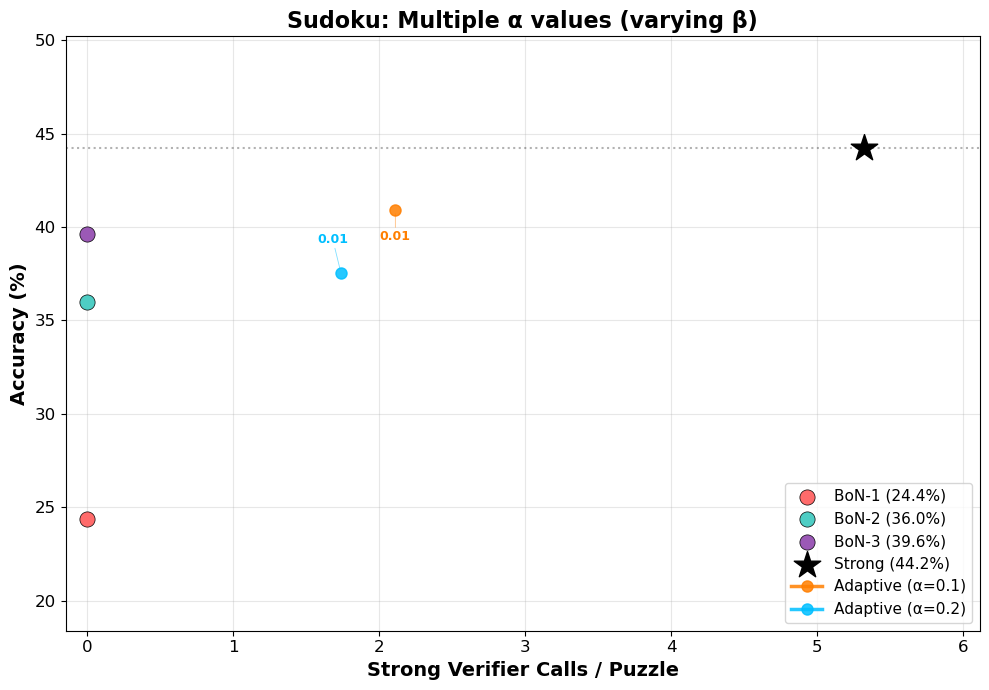

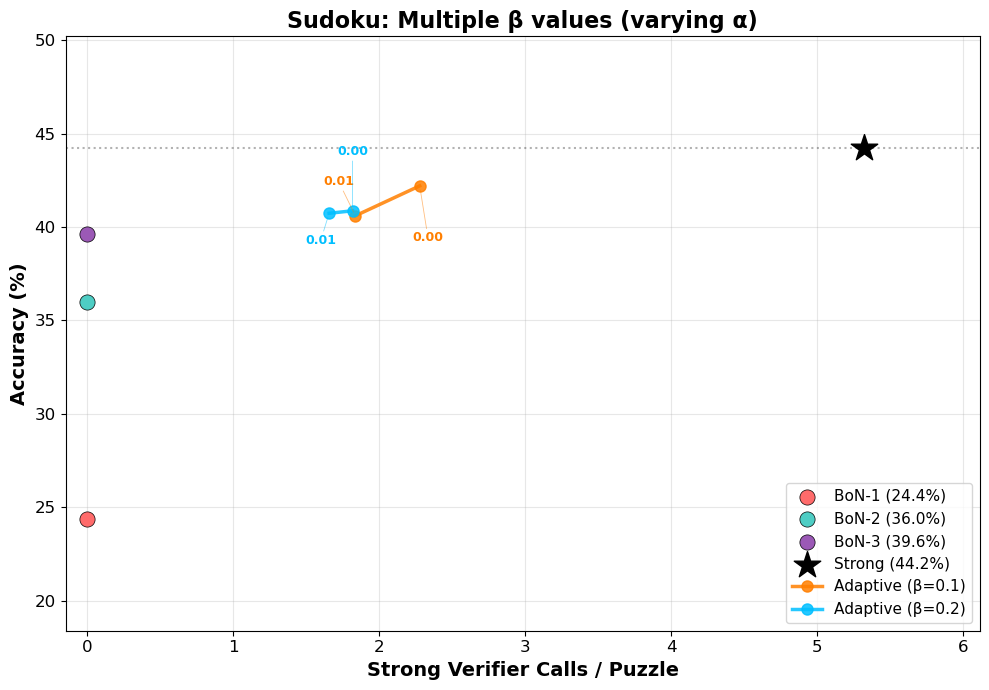

In [12]:
noise_scale = 0.1
fixed_values = [0.01, 0.05, 0.1, 0.2]

# --- Symmetric ---
try:
    results_symmetric = load_results(f'{SAVE_DIR}/results_symmetric_noise{noise_scale}.pkl')
    plot_accuracy_vs_latency_sudoku(results_symmetric,
        save_path=f'{SAVE_DIR}/plot_symmetric.png')
except FileNotFoundError:
    print('Symmetric results not found — run Section 3 first.')

# --- Alpha-fixed ---
alpha_fixed_results = {}
for fv in fixed_values:
    try:
        r = load_results(f'{SAVE_DIR}/results_alpha{fv}_betasweep_noise{noise_scale}.pkl')
        alpha_fixed_results[fv] = r
        plot_sweep_results(r, fixed_param='alpha', fixed_value=fv,
            save_path=f'{SAVE_DIR}/plot_alpha{fv}_betasweep.png')
    except FileNotFoundError:
        print(f'α={fv} not found')

# --- Beta-fixed ---
beta_fixed_results = {}
for fv in fixed_values:
    try:
        r = load_results(f'{SAVE_DIR}/results_alphasweep_beta{fv}_noise{noise_scale}.pkl')
        beta_fixed_results[fv] = r
        plot_sweep_results(r, fixed_param='beta', fixed_value=fv,
            save_path=f'{SAVE_DIR}/plot_alphasweep_beta{fv}.png')
    except FileNotFoundError:
        print(f'β={fv} not found')

# --- Overlays ---
if alpha_fixed_results:
    plot_accuracy_vs_latency_multi_alpha_sudoku(
        alpha_fixed_results,
        save_path=f'{SAVE_DIR}/plot_multi_alpha_betasweep.png',
    )
if beta_fixed_results:
    plot_accuracy_vs_latency_multi_beta_sudoku(
        beta_fixed_results,
        save_path=f'{SAVE_DIR}/plot_multi_beta_alphasweep.png',
    )